In [2]:
# Libraries import 
import tensorflow as tf
#from tensorflow_federated import python as tff
import os
import numpy as np
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers
from tqdm import tqdm

Using TensorFlow backend.


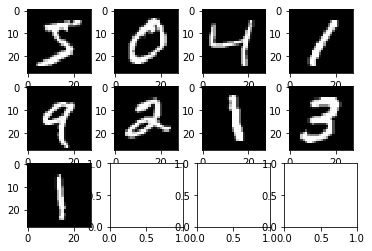

In [155]:
# Load and Normalize Data 
# 1. MNIST/EMNIST Data - handwritten things 
from emnist import extract_training_samples
def normalize(data, factor): 
    return ((data-factor)/factor)
def load_handwritten_data(digits_only=True):
    # load data
    if(digits_only): 
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
    else: 
        x_, y_ = extract_training_samples('letters')
        test_ind = np.random.randint(0, x_.shape[0], int(1/7*x_.shape[0]))
        x_test, y_test = x_[test_ind,...], y_[test_ind,...]
        x_train, y_train = np.delete(x_, test_ind, axis=0), np.delete(y_, test_ind,axis=0)
    
    # normalize data 
    normal_train_factor, normal_test_factor = np.max(x_train.flatten())/2, np.max(x_test.flatten())/2
    x_train, x_test = normalize(x_train, normal_train_factor), normalize(x_test, normal_test_factor)
    return(x_train, y_train, x_test, y_test)

# 2. COCO Dataset - 
def load_COCO_images():
    pass


# Visualizing the images 
import matplotlib.pyplot as plt
import math as m
def plot_imgs(imgs, plt_per_lines=4): 
    %matplotlib inline
    if(type(imgs) != list): 
        print("Please pass list of images")
        return
    n = len(imgs)
    fig, axs = plt.subplots(m.ceil(n/plt_per_lines),plt_per_lines)
    for i,ax in enumerate(axs.flat):
        if( i >= n): return
        ax.imshow(imgs[i], cmap="gray")
    plt.show()

train, y_train, test, y_test  = load_handwritten_data()
plot_imgs([i for i in train[0:9, ...]])

In [156]:
# Basic descriminator 
def discriminator(n_classes, image_shape): 
    dmod = Sequential()
    dmod.add(Dense(512, activation ='sigmoid',input_shape=image_shape))
    dmod.add(LeakyReLU(0.2))
    dmod.add(Dropout(1-0.3)) #reduces overfitting 
    dmod.add(Dense(n_classes, activation='softmax'))
    dmod.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.categorical_accuracy, 'accuracy'])
    return dmod

In [87]:
# Example descriminator - implemented here https://www.datacamp.com/community/tutorials/generative-adversarial-networks
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(1-0.3))

discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(1-0.3))

discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(1-0.3))

discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5),  metrics=[tf.keras.metrics.categorical_accuracy, 'accuracy'])
discriminator.evaluate(test.reshape(test.shape[0], test.shape[1]*test.shape[2]), y_test, batch_size=32)

In [158]:
# Train on MNIST
train, y_train, test, y_test  = load_handwritten_data()
y_ = np.eye(np.max(y_train)+1)[y_train.reshape(-1)]
dmod = discriminator(np.max(y_train)+1, (train.shape[1]*train.shape[2],))
dmod.fit(train.reshape(train.shape[0], -1), y_, epochs=10, batch_size=32 )

# Test on MNIST
y_t = np.eye(np.max(y_test)+1)[y_test.reshape(-1)]
dmod.evaluate(test.reshape(test.shape[0], test.shape[1]*test.shape[2]), y_t, batch_size=32)

Epoch 1/10
60000/60000 [==============================] - 9s 148us/step - loss: 0.0827 - categorical_accuracy: 0.8453 - acc: 0.9711
Epoch 2/10
60000/60000 [==============================] - 8s 129us/step - loss: 0.0530 - categorical_accuracy: 0.9063 - acc: 0.9818
Epoch 3/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.0461 - categorical_accuracy: 0.9180 - acc: 0.9840
Epoch 4/10
60000/60000 [==============================] - 8s 133us/step - loss: 0.0406 - categorical_accuracy: 0.9291 - acc: 0.9862
Epoch 5/10
60000/60000 [==============================] - 8s 129us/step - loss: 0.0386 - categorical_accuracy: 0.9313 - acc: 0.9867
Epoch 6/10
60000/60000 [==============================] - 8s 129us/step - loss: 0.0362 - categorical_accuracy: 0.9365 - acc: 0.9876
Epoch 7/10
60000/60000 [==============================] - 8s 131us/step - loss: 0.0351 - categorical_accuracy: 0.9387 - acc: 0.9880
Epoch 8/10
60000/60000 [==============================] - 8s 133us/step - lo

[0.01785312139845919, 0.9689, 0.9940099990844726]

In [160]:
# Train on EMNIST
etrain, eytrain, etest, eytest  = load_handwritten_data(False)
ey_  = np.eye(np.max(eytrain)+1)[eytrain.reshape(-1)]
dmod = discriminator(np.max(eytrain)+1, (etrain.shape[1]*etrain.shape[2],))
dmod.fit(etrain.reshape(etrain.shape[0],-1), ey_, batch_size=32, epochs=10)

# Test on EMNIST
ey_t = np.eye(np.max(eytest)+1)[eytest.reshape(-1)]
dmod.evaluate(etest.reshape(etest.shape[0], -1), ey_t, batch_size=32)

Epoch 1/10
108140/108140 [==============================] - 16s 145us/step - loss: 0.0688 - categorical_accuracy: 0.6347 - acc: 0.9766
Epoch 2/10
108140/108140 [==============================] - 15s 137us/step - loss: 0.0500 - categorical_accuracy: 0.7403 - acc: 0.9824
Epoch 3/10
108140/108140 [==============================] - 15s 142us/step - loss: 0.0452 - categorical_accuracy: 0.7695 - acc: 0.9841
Epoch 4/10
108140/108140 [==============================] - 14s 128us/step - loss: 0.0428 - categorical_accuracy: 0.7786 - acc: 0.9848
Epoch 5/10
108140/108140 [==============================] - 15s 136us/step - loss: 0.0414 - categorical_accuracy: 0.7893 - acc: 0.9854
Epoch 6/10
108140/108140 [==============================] - 14s 134us/step - loss: 0.0405 - categorical_accuracy: 0.7924 - acc: 0.9856
Epoch 7/10
108140/108140 [==============================] - 15s 141us/step - loss: 0.0397 - categorical_accuracy: 0.7961 - acc: 0.9859
Epoch 8/10
108140/108140 [=============================

[0.024976118354284364, 0.8760376935158178, 0.9911645736720013]

In [161]:
# TODO
# Train on COCO


# Test on COCO